Основная цель проекта: разработать модель предсказания стоимости автомобиля на вторичном рынке.

В рамках анализа будет проведена работа с данными. Набор данных содержит информацию об идентификаторе каждого автомобиля, его цены и общих характеристиках (пробег, цвет, модель, марка и т.д.)

# Работа с файлом данных, изучение общей информации

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib as plt
from tqdm import tqdm

import seaborn as sns

import os

from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error


from catboost import CatBoostRegressor
from catboost import Pool, cv
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('datasets/train.csv')
test = pd.read_csv('datasets/test.csv')
submission = pd.read_csv('datasets/sample_submission.csv')
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
def data_analis (data):
    info = data.info()
    head = data.head()
    describe = data.describe()
    duplicated = data.duplicated().sum()
    isna = round(data.isna().mean() * 100)
    return print(info),print(),print(head),print(), print(describe),print('Количество дубликатов:',duplicated),print(),print(isna)

In [4]:
data_analis(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB
None

   year    make   model    trim   body transmission                vin 

(None, None, None, None, None, None, None, None)

Таким образом, на этапе изучения данных датасета были обнаружены пропуски в столбцах: make, model, trim, body, transmission и condition.

# Предобработка данных

### 1.1 Приведение к змеиному стилю

In [5]:
# Приводим столбцы к общему стилю
train = train.rename(
    columns={'sellingprice' : 'selling_price',
             'saledate' : 'sale_date'}
)

test = test.rename(
    columns={'sellingprice' : 'selling_price',
             'saledate' : 'sale_date'}
)

### 1.2 Работа с пропусками

In [6]:
# удаляем пропуски в датасете train
train = train.dropna()

In [7]:
train['sale_date']=pd.to_datetime(train['sale_date'],utc=True)

In [8]:
datas =[train]
for data in datas:
    for column in ['selling_price', 'condition', 'odometer']:
        data[column] = data[column].astype(int)

In [9]:
test['sale_date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 110058 entries, 0 to 110057
Series name: sale_date
Non-Null Count   Dtype 
--------------   ----- 
110058 non-null  object
dtypes: object(1)
memory usage: 860.0+ KB


In [10]:
# В категориальных столбцах необходимо на всякий случай удалить лишние пробелы. 
columns=['make', 'model', 'trim', 'body', 'vin', 'state', 'color', 'interior', 'seller']
for i in columns:
    train[i] = train[i].str.strip()
    train[i] = train[i].str.lower()

In [11]:
train['make'].unique()

array(['ford', 'nissan', 'hummer', 'lincoln', 'hyundai', 'buick',
       'chevrolet', 'honda', 'acura', 'cadillac', 'gmc', 'saab', 'dodge',
       'toyota', 'volkswagen', 'bmw', 'infiniti', 'chrysler', 'kia',
       'jaguar', 'subaru', 'jeep', 'lexus', 'scion', 'fiat', 'mazda',
       'volvo', 'audi', 'mini', 'isuzu', 'mercedes-benz', 'mitsubishi',
       'smart', 'pontiac', 'porsche', 'land rover', 'suzuki', 'saturn',
       'ram', 'oldsmobile', 'mercury', 'bentley', 'fisker', 'maserati',
       'tesla', 'rolls-royce', 'plymouth', 'ferrari', 'lamborghini',
       'geo', 'aston martin', 'daewoo'], dtype=object)

In [12]:
a = ['mercedes','mercedes-b']
b = 'mercedes-benz'

c = ['landrover','land rover']
d = 'land_rover'

e = 'vw'
f = 'volkswagen'

train['make']= train['make'].replace(a, b)
train['make']= train['make'].replace(c, d)
train['make']= train['make'].replace(e, f)

In [13]:
train['make'].unique()

array(['ford', 'nissan', 'hummer', 'lincoln', 'hyundai', 'buick',
       'chevrolet', 'honda', 'acura', 'cadillac', 'gmc', 'saab', 'dodge',
       'toyota', 'volkswagen', 'bmw', 'infiniti', 'chrysler', 'kia',
       'jaguar', 'subaru', 'jeep', 'lexus', 'scion', 'fiat', 'mazda',
       'volvo', 'audi', 'mini', 'isuzu', 'mercedes-benz', 'mitsubishi',
       'smart', 'pontiac', 'porsche', 'land_rover', 'suzuki', 'saturn',
       'ram', 'oldsmobile', 'mercury', 'bentley', 'fisker', 'maserati',
       'tesla', 'rolls-royce', 'plymouth', 'ferrari', 'lamborghini',
       'geo', 'aston martin', 'daewoo'], dtype=object)

### 1.3 Выбросы

array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'condition'}>],
       [<Axes: title={'center': 'odometer'}>,
        <Axes: title={'center': 'selling_price'}>],
       [<Axes: title={'center': 'sale_date'}>, <Axes: >]], dtype=object)

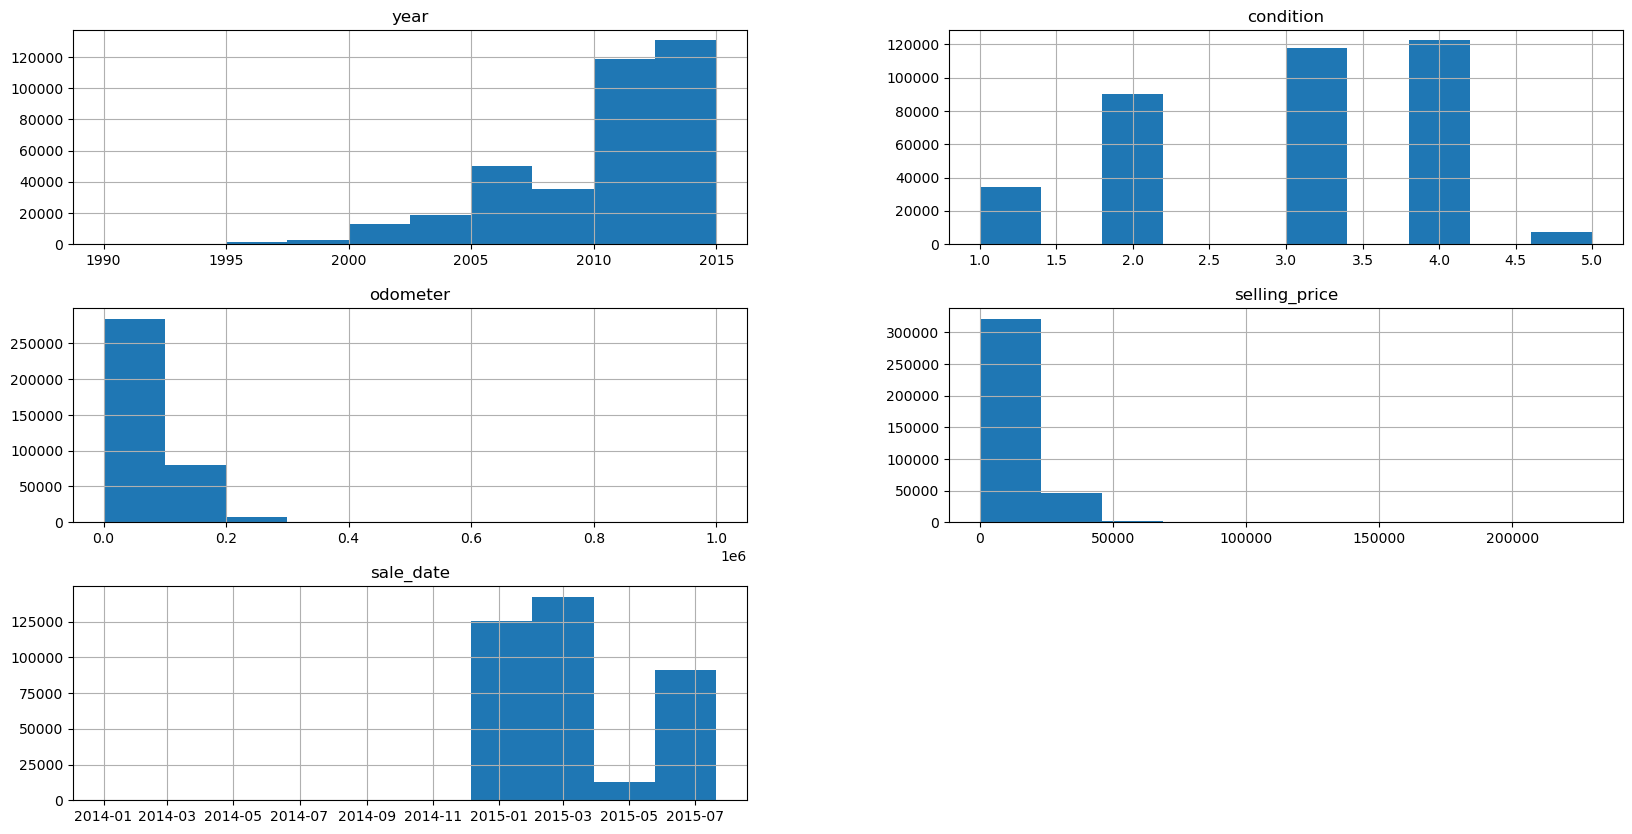

In [14]:
train.hist(figsize = (20, 10))

In [15]:
# Устранены редкие и выбивающиеся значения (аномалии) в столбце цена продажи
train.drop(train[train['selling_price'] == 0].index, inplace=True)
train.drop(train[train['selling_price'] < train.selling_price.quantile(.05)].index, inplace=True)
train.drop(train[train['selling_price'] > train.selling_price.quantile(.9999)].index, inplace=True)

# Устранены редкие и выбивающиеся значения (аномалии) в столбце год
train.drop(train[train['year'] < 2000].index, inplace=True)

# Устранены редкие и выбивающиеся значения (аномалии) в столбце пробег
train.drop(train[train['odometer'] > train.odometer.quantile(.95)].index, inplace=True)

На этапе предобработке данных были удалены пропуски в датасете train. Столбцы были приведены к общему змеиному стилю. В категориальных столбцах были удалены лишние пробелы и приведены записи к нижнему регистру. Также в ходе работы были обнаружены и устранены аномалии в датасете.

# Исследовательский анализ данных

<Axes: >

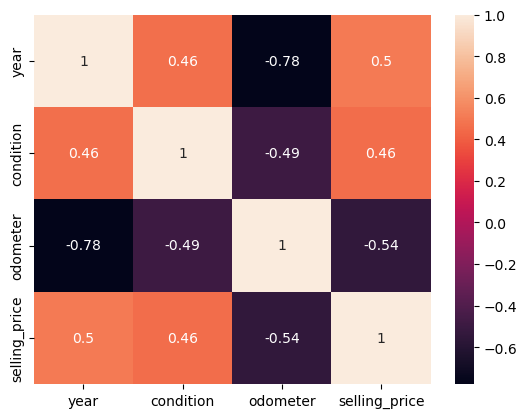

In [16]:
sns.heatmap(train.corr(),annot=True)

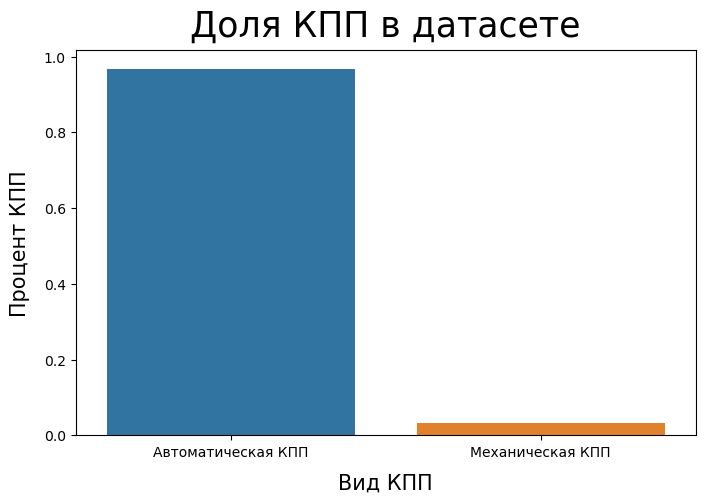

In [17]:
import matplotlib.pyplot as plt

datas = [train]
for data in datas:
    plt.figure(figsize = (8, 5)) 
    plt.title('Доля КПП в датасете', fontsize = 25, pad = 10)
    sns.barplot(x = data['transmission'].unique(), 
               y = data['transmission'].value_counts(normalize = True))
    plt.xlabel('Вид КПП', fontsize = 15, labelpad = 10)
    plt.ylabel('Процент КПП', fontsize = 15, labelpad = 10)
    plt.xticks(ticks = [0, 1], labels = ['Автоматическая КПП', 'Механическая КПП'])
    plt.show()

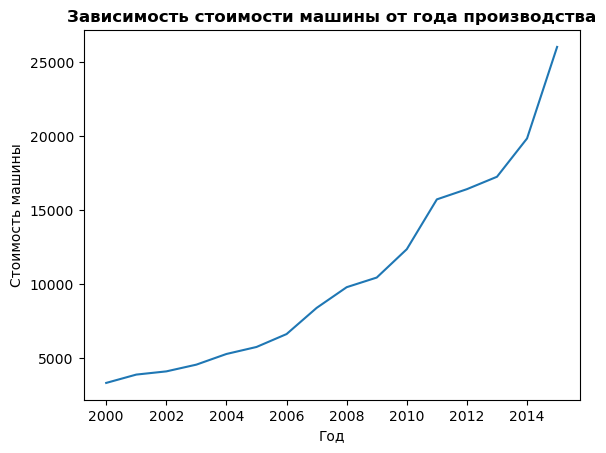

In [18]:
datas =[train]
for data in datas:
    data.pivot_table(index = ['year'],
                     values = 'selling_price', aggfunc = 'mean').plot(legend = None) 
    plt.xlim()
    plt.xlabel('Год')
    plt.ylabel('Стоимость машины')
    plt.title('Зависимость стоимости машины от года производства', fontweight = "bold")
    plt.show()

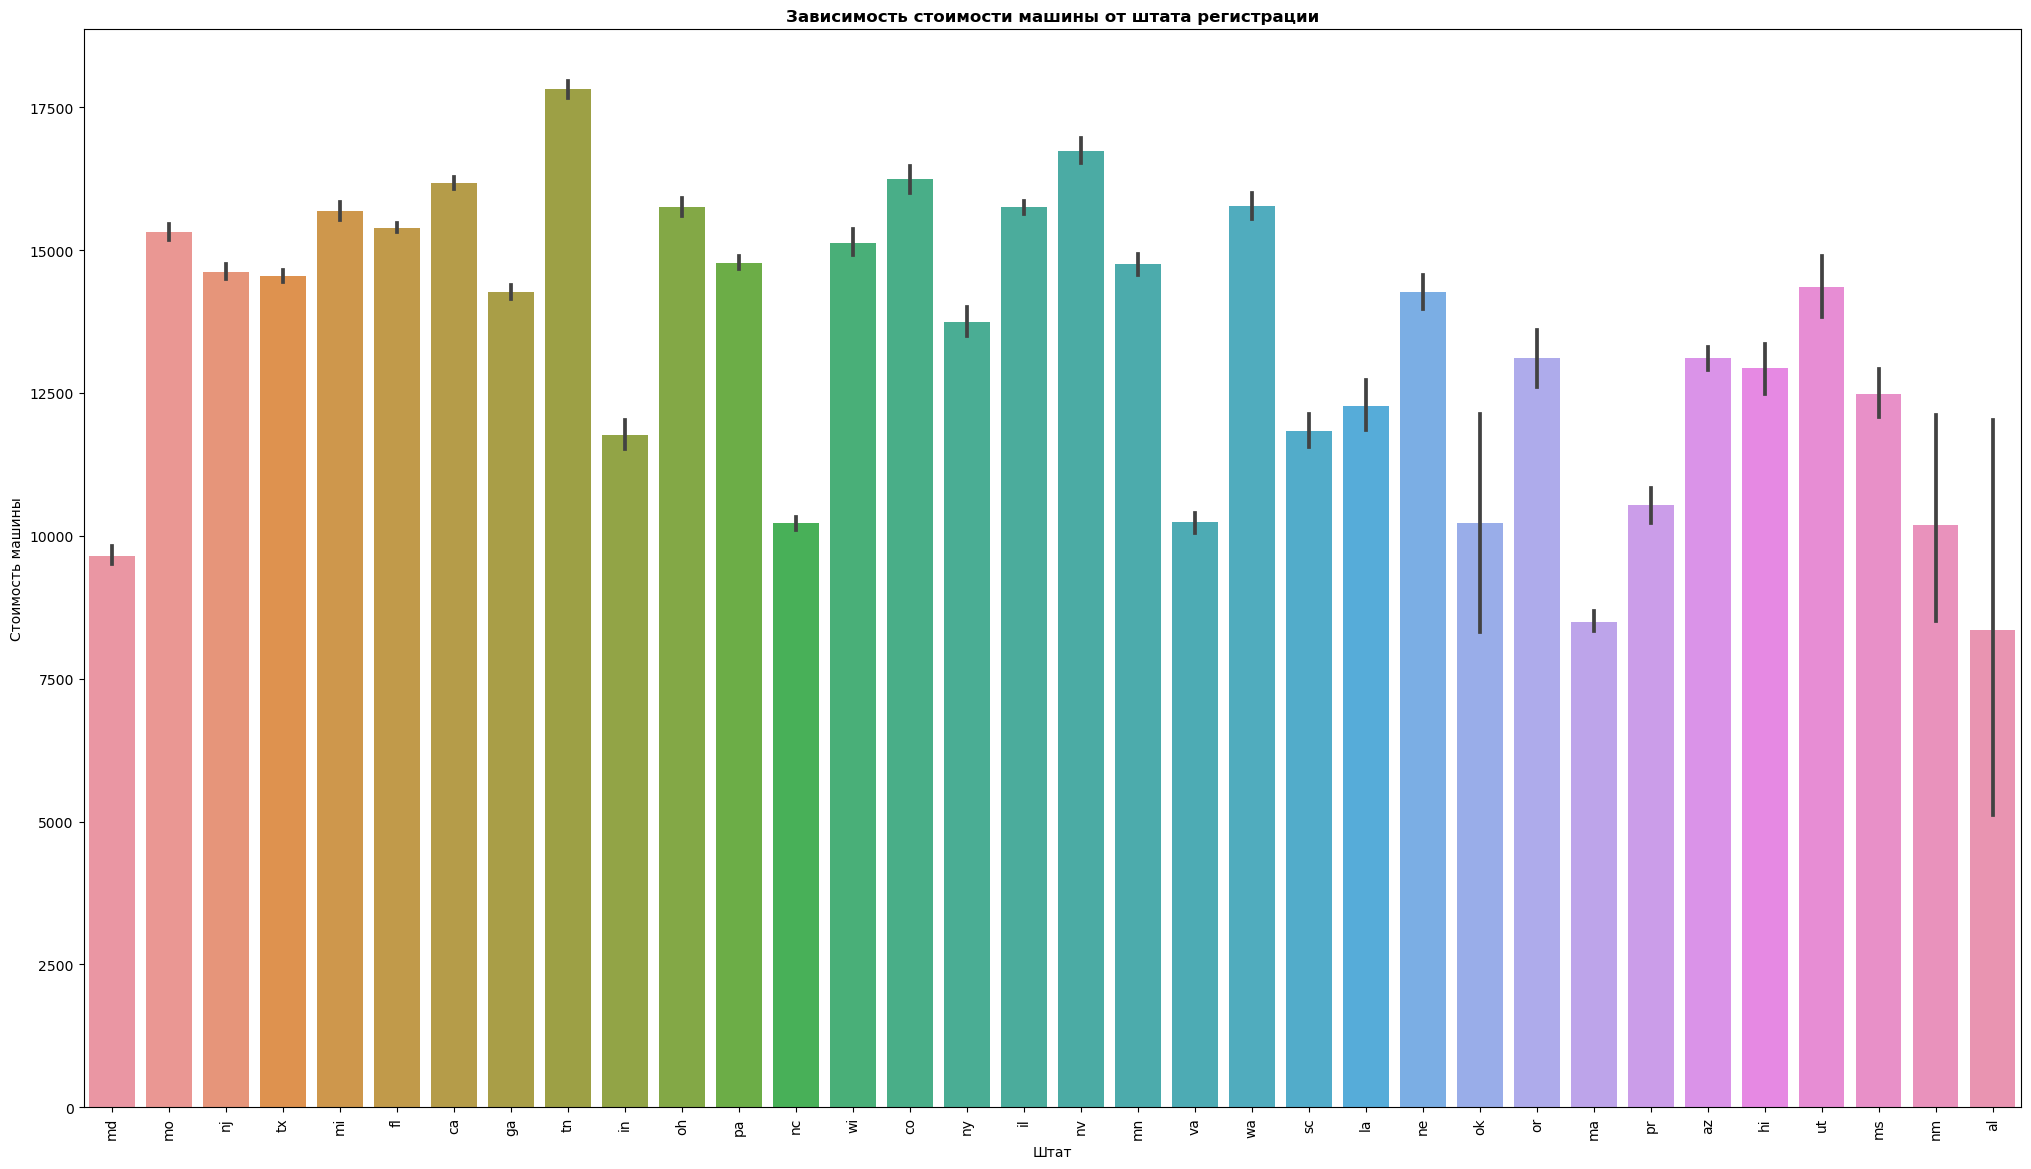

In [19]:
for data in datas:
    plt.figure(figsize=[25,14]) 
    sns.barplot(x = data['state'], y = data['selling_price']).tick_params('x', rotation = 90)
    plt.title('Зависимость стоимости машины от штата регистрации', fontweight = 'bold')
    plt.xlabel('Штат')
    plt.ylabel('Стоимость машины')
    plt.show()

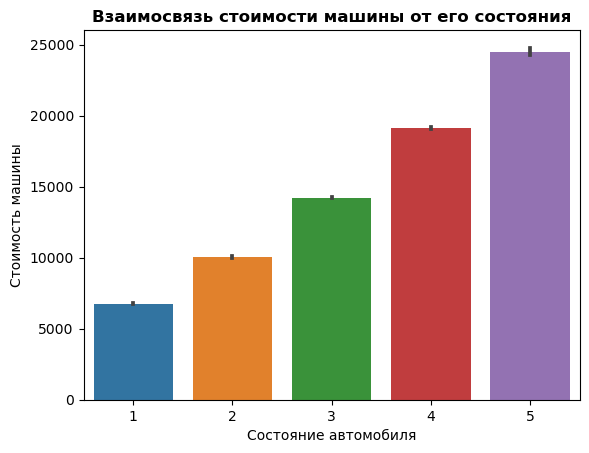

In [20]:
for data in datas:
    sns.barplot(x = data['condition'], y = data['selling_price'])
    plt.title('Взаимосвязь стоимости машины от его состояния', fontweight = 'bold')
    plt.xlabel('Состояние автомобиля')
    plt.ylabel('Стоимость машины')
    plt.show()

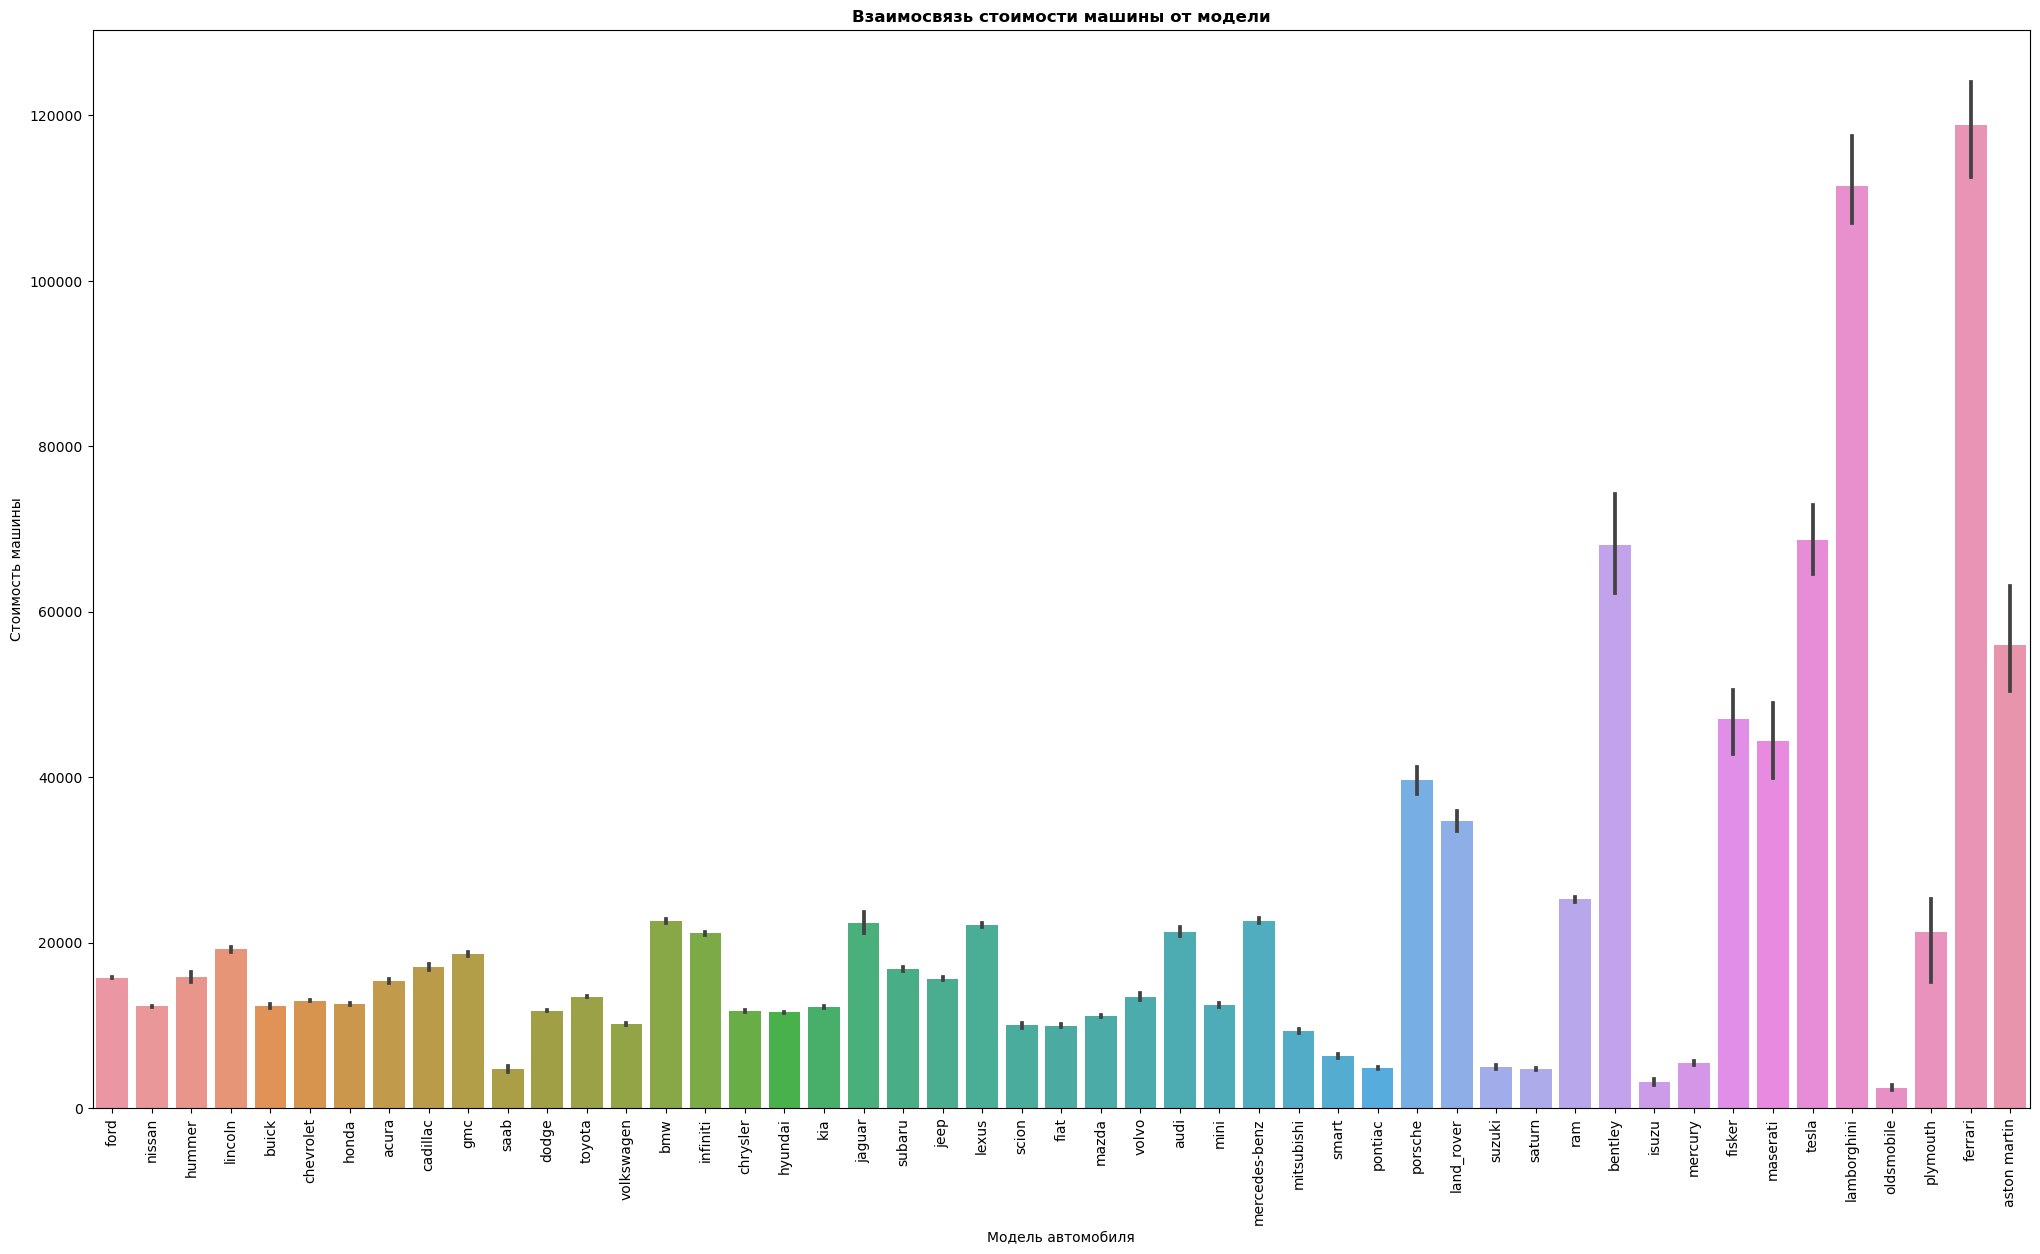

In [21]:
for data in datas:
    plt.figure(figsize=[25,14])  
    sns.barplot(x = data['make'], y = data['selling_price']).tick_params('x', rotation = 90)
    plt.title('Взаимосвязь стоимости машины от модели', fontweight = 'bold')
    plt.xlabel('Модель автомобиля')
    plt.ylabel('Стоимость машины')
    plt.show()

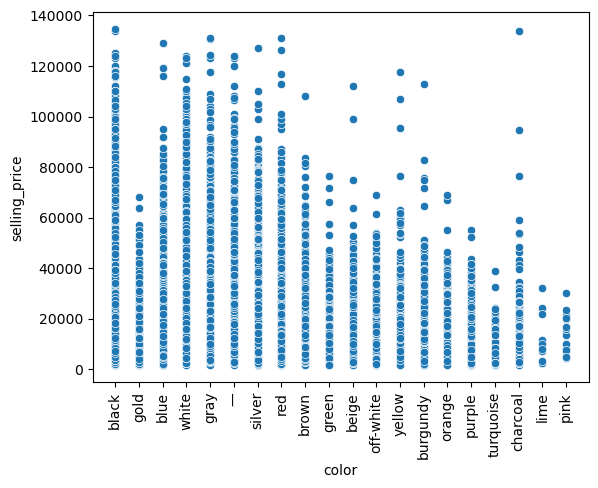

In [22]:
ax = sns.scatterplot(data = train, x = 'color', y = 'selling_price').tick_params('x', rotation = 90)

In [23]:
mean_cost = train.groupby(['color'])['selling_price'].mean().round().reset_index()
mean_cost.rename(columns = {'color':'Цвет машины', 'selling_price': 'Средняя стоимость'}, inplace = True)
i = train.groupby('color')['vin'].count().reset_index()
mean_cost['Количество проданных машин'] = i['vin']
ii = train.groupby('color')['selling_price'].max().reset_index()
mean_cost['Цена самых дорогих машин'] = ii['selling_price']
mean_cost.sort_values(by = 'Цена самых дорогих машин')

,Цвет машины,Средняя стоимость,Количество проданных машин,Цена самых дорогих машин
12,pink,"12,291.00",28,30000
9,lime,"11,941.00",11,32100
16,turquoise,"10,418.00",119,38750
13,purple,"13,716.00",891,55000
6,gold,"10,684.00",5691,68000
11,orange,"13,649.00",1292,69000
10,off-white,"16,391.00",912,69000
8,green,"11,624.00",5203,76500
3,brown,"16,451.00",4081,108000
0,beige,"11,534.00",4563,112000


Таким образом, проведя исследование было установлено, что столбцы vin, sale_date, seller можно удалить из датасета, так как не сильно влияют на формирование стоимости машины. Остальные параметры было решено оставить, наблюдается сильная корреляция между ценной и показателями.

# Создание модели

In [24]:
# Заменим пропуски в столбце condition
train['condition'] = train['condition'].fillna(train['condition'].corr(train['odometer']))

In [25]:
# Необходимо удалить столбцы, которые не нужны для создания модели
train = train.drop(['vin','sale_date','seller' ],axis=1)

In [26]:
train, test = train_test_split(train,random_state=3826)

In [27]:
cat_features = list(train.select_dtypes(include='object').columns)
cat_features

['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior']

In [28]:
# Заменим пропуски в каготериальных столбцах на unknown:
train[cat_features]= train[cat_features].fillna('unknow')
test[cat_features]= test[cat_features].fillna('unknow')

In [29]:
print(test.shape)
print(train.shape)

(83952, 12)
(251856, 12)


In [30]:
x = ['make', 'model', 'body', 'transmission','year','condition','odometer','trim','interior','state','color']
y = ['selling_price']

**CatBoostRegressor**

In [31]:
train_data= Pool(data = train[x],
                label = train[y],
                 cat_features = cat_features)
test_data= Pool(data = test[x],
                label = test[y],
                 cat_features = cat_features)

In [32]:
params={'eval_metric':'MAPE',
       'loss_function':'RMSE',
        'task_type':'GPU',
       'learning_rate':0.1,
       'random_seed':3826,
       'verbose':100}

In [33]:
cv_data = cv(params = params,
          pool = train_data,
          fold_count = 5,
          shuffle = True,
          partition_random_seed = 0,
          stratified = True, 
          verbose = False,
          early_stopping_rounds = 200,)

Training on fold [0/5]


bestTest = 0.1286734304
bestIteration = 992
Training on fold [1/5]


bestTest = 0.1346067214
bestIteration = 999
Training on fold [2/5]


bestTest = 0.1361362891
bestIteration = 998
Training on fold [3/5]


bestTest = 0.1345749458
bestIteration = 958
Training on fold [4/5]


bestTest = 0.1363469879
bestIteration = 995


In [34]:
model = CatBoostRegressor(**params)

In [35]:
model.fit(train_data)

0:	learn: 0.7201603	total: 36.1ms	remaining: 36.1s
100:	learn: 0.1588395	total: 2.9s	remaining: 25.8s
200:	learn: 0.1431073	total: 5.51s	remaining: 21.9s
300:	learn: 0.1363749	total: 8.16s	remaining: 19s
400:	learn: 0.1316823	total: 10.8s	remaining: 16.2s
500:	learn: 0.1286644	total: 13.5s	remaining: 13.5s
600:	learn: 0.1253935	total: 16.3s	remaining: 10.8s
700:	learn: 0.1233126	total: 19s	remaining: 8.09s
800:	learn: 0.1213569	total: 21.7s	remaining: 5.39s
900:	learn: 0.1195834	total: 24.4s	remaining: 2.68s
999:	learn: 0.1183890	total: 27.1s	remaining: 0us


In [36]:
prediction_1 = model.predict(test_data)

In [37]:
mean_absolute_percentage_error(test['selling_price'], prediction_1)

0.11715988533971707

**Optuna + CatBoostRegressor**

In [38]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [39]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [40]:
import optuna
import catboost as cb

In [44]:
def model(trial):
    params={'eval_metric':'MAPE',
            'loss_function':'RMSE',
            'learning_rate':trial.suggest_loguniform('learning_rate', 0.01, 0.4),
            'depth': trial.suggest_int('depth', 2, 15, step = 1),
            'colsample_bylevel': trial.suggest_discrete_uniform('colsample_bylevel', 0.4, 0.9, 0.1),
            'n_estimators': trial.suggest_int('n_estimators', 10, 2510, step = 50),
            'random_seed': 12345,
            'verbose': 100}
    model = cb.CatBoostRegressor(**params)
    model.fit(train_data, verbose = False)
    prediction_2 = model.predict(test_data)
    mape = mean_absolute_percentage_error(test['selling_price'], prediction_2)
    return mape

In [45]:
study = optuna.create_study(direction="minimize")
study.optimize(model, n_trials=3)

[I 2023-06-02 19:12:28,946] A new study created in memory with name: no-name-055aa6af-1dff-4a5c-bd44-5b147630eb76
[I 2023-06-02 19:32:38,682] Trial 0 finished with value: 0.10346295789485715 and parameters: {'learning_rate': 0.020886352317822012, 'depth': 14, 'colsample_bylevel': 0.7000000000000001, 'n_estimators': 1810}. Best is trial 0 with value: 0.10346295789485715.
[I 2023-06-02 19:32:59,751] Trial 1 finished with value: 0.13570735421357308 and parameters: {'learning_rate': 0.21718863133722158, 'depth': 5, 'colsample_bylevel': 0.7000000000000001, 'n_estimators': 260}. Best is trial 0 with value: 0.10346295789485715.
[I 2023-06-02 19:33:51,735] Trial 2 finished with value: 0.173460670885851 and parameters: {'learning_rate': 0.01603141910342299, 'depth': 3, 'colsample_bylevel': 0.6000000000000001, 'n_estimators': 1310}. Best is trial 0 with value: 0.10346295789485715.


**Optuna + CatBoostRegressor 2.0**

In [46]:
def model(trial):
    params={'eval_metric':'MAPE',
            'loss_function':'RMSE',
            'learning_rate':trial.suggest_loguniform('learning_rate', 0.01, 0.4),
            'depth': trial.suggest_int('depth', 2, 15, step = 1),
            'colsample_bylevel': trial.suggest_discrete_uniform('colsample_bylevel', 0.4, 0.9, 0.1),
            'n_estimators': trial.suggest_int('n_estimators', 10, 3010, step = 50),
            'random_seed': 199,
            }
    model = cb.CatBoostRegressor(**params)
    model.fit(train_data, verbose = False)
    prediction_3 = model.predict(test_data)
    mape = mean_absolute_percentage_error(test['selling_price'], prediction_3)
    return mape

In [47]:
study_3 = optuna.create_study(direction="minimize")
study_3.optimize(model, n_trials=3)

[I 2023-06-02 19:38:20,581] A new study created in memory with name: no-name-fb350d59-88fb-4de6-980b-3a078acbc153
[I 2023-06-02 20:04:06,134] Trial 0 finished with value: 0.11509407394819147 and parameters: {'learning_rate': 0.3697902173477225, 'depth': 14, 'colsample_bylevel': 0.4, 'n_estimators': 2810}. Best is trial 0 with value: 0.11509407394819147.
[I 2023-06-02 20:08:44,333] Trial 1 finished with value: 0.10504087074877985 and parameters: {'learning_rate': 0.30271406431883563, 'depth': 9, 'colsample_bylevel': 0.9, 'n_estimators': 1460}. Best is trial 1 with value: 0.10504087074877985.
[I 2023-06-02 20:08:44,854] Trial 2 finished with value: 0.25568233845325555 and parameters: {'learning_rate': 0.34002523650118144, 'depth': 3, 'colsample_bylevel': 0.9, 'n_estimators': 10}. Best is trial 1 with value: 0.10504087074877985.


In [52]:
best_params_2 = study.best_params
best_score_2 = study.best_value

In [54]:
print(f'Лучшее параметры: {best_params_2}')
print(f'Лучший результат: {best_score_2}')

Лучшее параметры: {'learning_rate': 0.020886352317822012, 'depth': 14, 'colsample_bylevel': 0.7000000000000001, 'n_estimators': 1810}
Лучший результат: 0.10346295789485715


In [55]:
best_params_3 = study_3.best_params
best_score_3 = study_3.best_value

In [56]:
print(f'Лучшее параметры: {best_params_3}')
print(f'Лучший результат: {best_score_3}')

Лучшее параметры: {'learning_rate': 0.30271406431883563, 'depth': 9, 'colsample_bylevel': 0.9, 'n_estimators': 1460}
Лучший результат: 0.10504087074877985


**RandomForestRegressor**

In [73]:
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.compose import make_column_transformer, make_column_selector

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [74]:
ensemble_transformer = make_column_transformer(
    (
        OrdinalEncoder(
            dtype='int16',
            handle_unknown='use_encoded_value',
            unknown_value=-1
        ), make_column_selector(dtype_include='object')
    ),
    remainder='passthrough'
)

pipe_rf = make_pipeline(
    ensemble_transformer,
    RandomForestRegressor(
        oob_score=True,
        n_jobs=-1,
        verbose=0
    )
)


In [75]:
param_grid = {
    'randomforestregressor__max_depth':np.arange(5, 16, 5)
}

gs_rf = GridSearchCV(
    pipe_rf,
    param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

In [79]:
features_train = train.drop('selling_price', axis = 1)
features_test = test.drop('selling_price', axis = 1)

target_train = train['selling_price']
target_test = test['selling_price']

In [80]:
gs_rf.fit(features_train, target_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(dtype='int16',
                                                                                        handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001EDE43FB370>)])),
                                       ('randomforestregressor',
                                        RandomForestRegressor(n_jobs=-1,
                                                              oob_score=True))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': array([ 5, 10, 15])},
             scoring='neg_root_mean_squared_error', verbose=1)

In [83]:
prediction_4 = gs_rf.predict(features_test)
mean_absolute_percentage_error(test['selling_price'], prediction_4)

0.1460987364400002

**Вывод**: Основная цель исследования состояла в создании системы, которая предсказывает стоимость автомобиля на вторичном рынке. В качестве исходных данных анализа используется статистика, собранная заказчиком. Набор данных содержит информацию о производителе, модели, модификации, тип КПП и т.д.

В начале проекта была проведена подготовка данных. В ходе работы с данными были обнаружены и удалены строки, где наблюдались аномалии. Краткий анализ также показал, что явные дубликаты в датасете отсутствуют, пропуски были удалены, в целом данные чистые.

В результате проведённого исследования, наилучшей моделью для предсказания отмены бронирования оказалась модель CatBoostRegressor, так как она показала хорошую метрику mape = 0.103.